В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [334]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

path = "../../../data/"

df_train_raw = pd.read_csv(path + "train.csv")

In [335]:
train_set, val_set = train_test_split(df_train_raw, test_size=0.2, stratify=df_train_raw['Exited'], random_state=42)
print(train_set.shape, val_set.shape)
print(train_set['Exited'].value_counts(normalize=True))
print(val_set['Exited'].value_counts(normalize=True))

(12000, 14) (3000, 14)
Exited
0.0    0.7965
1.0    0.2035
Name: proportion, dtype: float64
Exited
0.0    0.796667
1.0    0.203333
Name: proportion, dtype: float64


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [336]:

input_cols = df_train_raw.drop(columns=['Exited']).columns.tolist()
target_col = 'Exited'
print(f"Input columns: {input_cols}, \ntarget column: {target_col}")

Input columns: ['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], 
target column: Exited


In [337]:
train_inputs = train_set[input_cols].copy()
train_targets = train_set[target_col].copy()

val_inputs = val_set[input_cols].copy()
val_targets = val_set[target_col].copy()

print(train_inputs.shape, train_targets.shape, val_inputs.shape, val_targets.shape)

(12000, 13) (12000,) (3000, 13) (3000,)


3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [338]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
print(numeric_cols)
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()
print(categorical_cols)

['id', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
['Surname', 'Geography', 'Gender']


4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [339]:
df_train_raw.info(), df_train_raw.isna().sum()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


(None,
 id                 0
 CustomerId         0
 Surname            0
 CreditScore        0
 Geography          0
 Gender             0
 Age                0
 Tenure             0
 Balance            0
 NumOfProducts      0
 HasCrCard          0
 IsActiveMember     0
 EstimatedSalary    0
 Exited             0
 dtype: int64)

In [340]:
train_inputs[numeric_cols].nunique()

id                 12000
CustomerId          5700
CreditScore          373
Age                   56
Tenure                11
Balance             2895
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     5502
dtype: int64

In [341]:
train_inputs[numeric_cols].describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.000000,1.200000e+04,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,7479.628917,1.569092e+07,658.840250,37.687917,5.026083,43008.174362,1.590250,0.790333,0.491583,117992.400015
std,4334.088776,1.469310e+05,72.334909,8.138440,2.781974,59906.627660,0.532646,0.407088,0.499950,45589.484607
min,0.000000,1.581102e+06,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,3725.750000,1.563512e+07,603.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,83343.730000
50%,7471.500000,1.568995e+07,661.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,123613.910000
75%,11231.250000,1.575692e+07,708.000000,42.000000,7.000000,109949.050000,2.000000,1.000000,1.000000,156912.810000
max,14999.000000,1.581569e+07,850.000000,74.000000,10.000000,209767.310000,4.000000,1.000000,1.000000,199992.480000


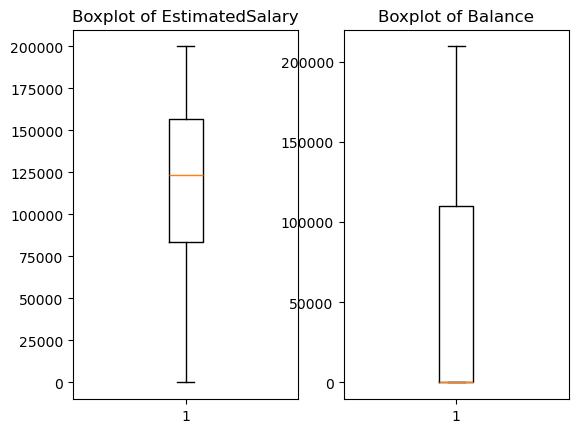

In [342]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.boxplot(train_inputs['EstimatedSalary'])
plt.title('Boxplot of EstimatedSalary')

plt.subplot(1, 2, 2)
plt.boxplot(train_inputs['Balance'])
plt.title('Boxplot of Balance')
plt.show()

In [343]:
train_inputs['Balance'].describe( percentiles=[ 0.50, 0.60, 0.75, 0.90, 0.95, 0.99])

count     12000.000000
mean      43008.174362
std       59906.627660
min           0.000000
50%           0.000000
60%           0.000000
75%      109949.050000
90%      134451.163000
95%      145579.638000
99%      167557.120000
max      209767.310000
Name: Balance, dtype: float64

In [344]:
# train_inputs.drop(columns=['CustomerId', 'id'], inplace=True)
# val_inputs.drop(columns=['CustomerId', 'id'], inplace=True)
numeric_cols.remove('CustomerId')
numeric_cols.remove('id')
numeric_cols

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [345]:
train_inputs[categorical_cols].nunique()

Surname      732
Geography      3
Gender         2
dtype: int64

In [346]:
# train_inputs.drop(columns='Surname', inplace=True)
categorical_cols.remove('Surname')
categorical_cols

['Geography', 'Gender']

In [347]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

preproc_type ='standard' #minmax

binary_cols = ['HasCrCard', 'IsActiveMember']
if preproc_type == 'standard':

    scaler = StandardScaler()
    scaler.fit(train_inputs[numeric_cols])
    train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
    val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
# else:
#     scaler = MinMaxScaler()
#     scaler.fit(train_inputs[numeric_cols])
#     train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
#     val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

#----------------------
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop = 'if_binary')
encoder.fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])


['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']


In [348]:
display(train_inputs[numeric_cols + encoded_cols].head(), val_inputs[numeric_cols + encoded_cols].head())


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
7180,0.320187,-0.944682,-1.447264,1.475464,-1.108193,0.515062,1.016977,0.569450,1.0,0.0,0.0,1.0
10393,0.347838,0.161227,-1.087792,2.254434,-1.108193,0.515062,-0.983306,0.603803,1.0,0.0,0.0,0.0
80,0.638166,-0.330288,0.350096,1.223831,0.769304,0.515062,-0.983306,1.238026,0.0,1.0,0.0,1.0
3365,0.140460,2.495924,-1.806736,-0.717950,0.769304,-1.941514,1.016977,-1.457116,0.0,0.0,1.0,1.0
12236,0.665816,-2.050591,-0.728320,-0.717950,0.769304,0.515062,1.016977,0.670629,1.0,0.0,0.0,1.0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
6490,0.762592,1.021379,-1.447264,1.214543,4.524299,0.515062,1.016977,-0.988144,0.0,1.0,0.0,1.0
3646,-0.910252,0.406985,-0.009376,-0.717950,0.769304,0.515062,1.016977,-1.750392,1.0,0.0,0.0,1.0
5306,0.997620,0.038348,-1.087792,-0.717950,0.769304,-1.941514,1.016977,-0.022404,1.0,0.0,0.0,0.0
652,0.195761,0.652742,-0.368848,1.881867,-1.108193,-1.941514,1.016977,-0.139723,1.0,0.0,0.0,0.0
2627,0.264887,-0.944682,-0.368848,-0.717950,0.769304,0.515062,-0.983306,0.563519,0.0,0.0,1.0,0.0


Ідентифікатори: id, CustomerId, Surname.
Числові ознаки: CreditScore, Age, Tenure, Balance, NumOfProducts, EstimatedSalary.
Категоріальні ознаки: Geography, Gender, HasCrCard, IsActiveMember.
Цільова змінна: Exited.

- ordered= NumOfProducts: Кількість банківських продуктів, які використовує клієнт (наприклад, ощадний рахунок, кредитна картка)
- binary = HasCrCard: Чи має клієнт кредитну картку (1 = так, 0 = ні)
- binary = IsActiveMember: Чи є клієнт активним членом (1 = так, 0 = ні)

Немає пропущених значень, але потрібно перевірити коректність типів даних

План передобробки:

- Видалення нерелевантних ознак: id, CustomerId, Surname - не інформативні для моделі.
- Масштабування числових змінних: CreditScore, Age, Balance, EstimatedSalary тощо.
- Кодування категоріальних ознак: Geography, Gender, HasCrCard, IsActiveMember (One-Hot або Label Encoding).

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [349]:
train_inputs.to_parquet(path + 'train_inputs.parquet', index=False)
val_inputs.to_parquet(path + 'val_inputs.parquet', index=False)
train_targets.to_frame().to_parquet(path + 'train_targets.parquet', index=False)
val_targets.to_frame().to_parquet(path + 'val_targets.parquet', index=False)

In [350]:
import os
os.listdir(path)

['bank-customer-churn-prediction-dlu-course-c-2.zip',
 'cars.csv',
 'credit',
 'credit-20241209T185039Z-001.zip',
 'customer_segmentation_train.csv',
 'medical-charges.csv',
 'regression_data.csv',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 'train_inputs.parquet',
 'train_targets.parquet',
 'val_inputs.parquet',
 'val_targets.parquet']

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [351]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_train.columns, X_train.shape, X_val.shape

(Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
        'IsActiveMember', 'EstimatedSalary', 'Geography_France',
        'Geography_Germany', 'Geography_Spain', 'Gender_Male'],
       dtype='object'),
 (12000, 12),
 (3000, 12))

In [352]:
from sklearn.linear_model import LogisticRegression  

model = LogisticRegression()
model.fit(X_train, train_targets)


LogisticRegression()

In [353]:
model.predict_proba(X_train)[:,1][:5]

array([0.01301626, 0.26753732, 0.12116485, 0.37750233, 0.00156514])

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

Train f1: 0.639559913896197, auc: 0.7527215196706721


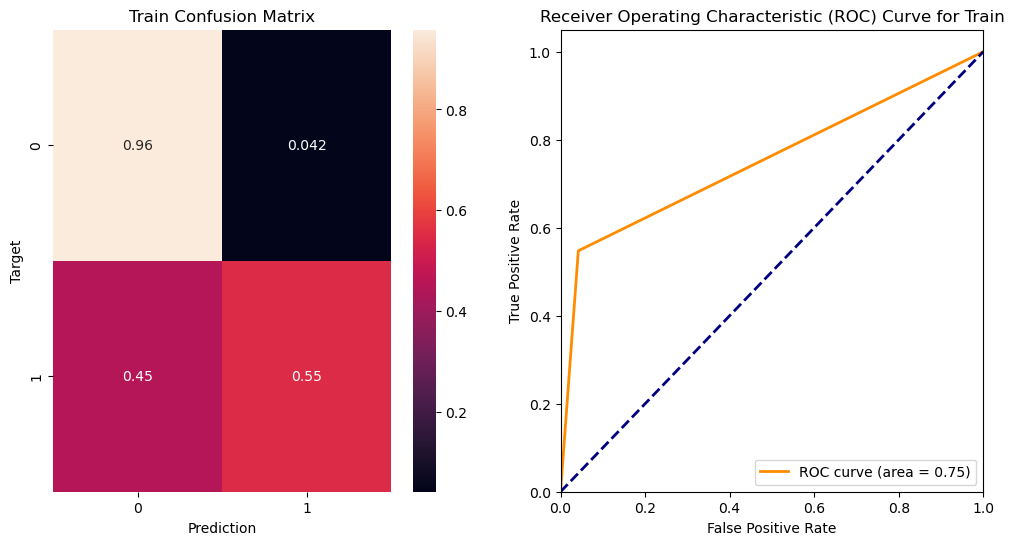

Val f1: 0.6389658356417359, auc: 0.7570375197201454


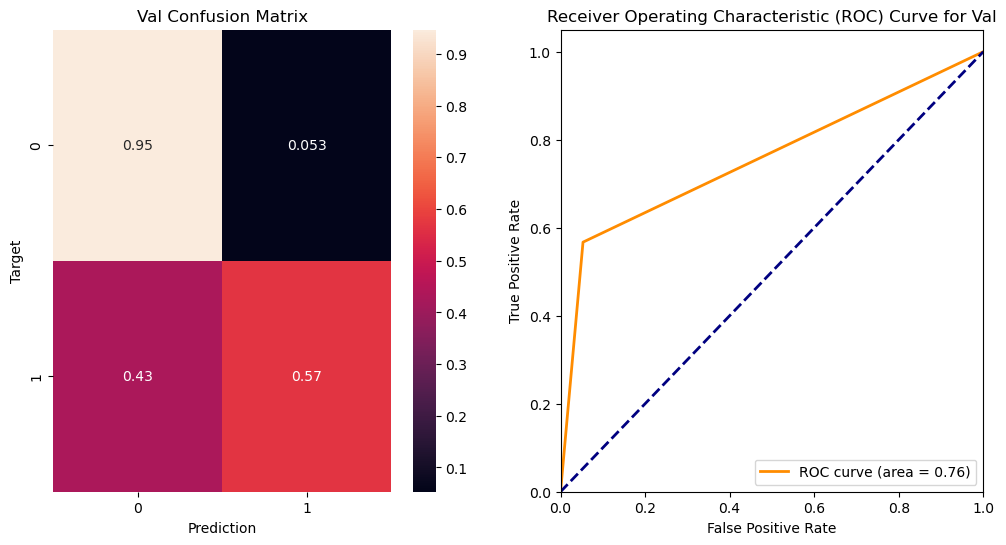

In [354]:
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, auc
import seaborn as sns

def predict_summary (inputs, targets, model, name=''):
    predictions = model.predict(inputs)
    f1 = f1_score(targets, predictions)
    auc_score = roc_auc_score(targets, predictions)   
    print(f'{name} f1: {f1}, auc: {auc_score}')

    cm = confusion_matrix(targets, predictions, normalize='true')

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    fpr, tpr, thresholds = roc_curve(targets, predictions)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()

    return predictions

train_predict = predict_summary(X_train, train_targets, model, 'Train')
val_predict = predict_summary(X_val, val_targets, model, 'Val')

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [355]:
from sklearn.metrics import accuracy_score

def major(inputs, majority):
    return np.full(len(inputs), majority)

majority = train_targets.mode()[0] 

majority_train_pred = major(X_train, majority)
majority_val_pred = major(X_val, majority)

train__major_acc = accuracy_score(train_targets, majority_train_pred)
val_major_acc = accuracy_score(val_targets, majority_val_pred)
print(f'Majority class train accuracy: {train__major_acc:.04}, val accuracy: {val_major_acc:.04}')

train_acc_6 = accuracy_score(train_targets, train_predict)
val_acc_6 = accuracy_score(val_targets, val_predict)
print(f'Log. regres. train accuracy: {train_acc_6:.04}, val accuracy: {val_acc_6:.04}')

Majority class train accuracy: 0.7965, val accuracy: 0.7967
Log. regres. train accuracy: 0.8744, val accuracy: 0.8697


9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [356]:
import joblib
bank_1 = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

joblib.dump(bank_1, 'bank_1.joblib')

['bank_1.joblib']

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [368]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
   
    X_input = input_df[numeric_cols + encoded_cols]
    # print(X_input.head())
    print(X_input.shape)

    prob = model.predict_proba(X_input)[:,1]
    
    
    return prob

In [369]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, train_set[:5])


(5, 12)


array([0.01301626, 0.26753732, 0.12116485, 0.37750233, 0.00156514])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [372]:
test_raw_df = pd.read_csv(path + 'test.csv')
test_prob = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)
print (test_prob[:5])

test_raw_df['Exited'] = test_prob
test_raw_df.head()


(10000, 12)
[0.06927028 0.03328608 0.15361416 0.19839602 0.05404912]


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male,Exited
0,15000,15594796.0,Chu,-1.034678,Germany,Male,-0.944682,-1.087792,1.720173,-1.108193,0.515062,1.016977,0.875226,0.0,1.0,0.0,1.0,0.069270
1,15001,15642821.0,Mazzi,-1.490909,France,Male,0.161227,-0.009376,-0.717950,0.769304,0.515062,1.016977,-1.109098,1.0,0.0,0.0,1.0,0.033286
2,15002,15716284.0,Onyekachi,0.651991,France,Male,0.652742,1.069040,-0.717950,0.769304,0.515062,-0.983306,0.850584,1.0,0.0,0.0,1.0,0.153614
3,15003,15785078.0,Martin,0.804068,Spain,Male,0.898500,-0.728320,-0.717950,-1.108193,0.515062,1.016977,1.073044,0.0,0.0,1.0,1.0,0.198396
4,15004,15662955.0,Kenechukwu,-0.924077,Spain,Male,0.652742,1.069040,-0.717950,0.769304,0.515062,1.016977,0.563521,0.0,0.0,1.0,1.0,0.054049


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [375]:
submit = pd.read_csv(path + 'sample_submission.csv')
submit['Exited'] = test_raw_df['Exited']
submit.head()

,id,Exited
0,15000,0.069270
1,15001,0.033286
2,15002,0.153614
3,15003,0.198396
4,15004,0.054049


In [376]:
submit.to_csv(path + 'submission_log_reg.csv', index=False)